In [1]:
#python3
#import libraries
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import time
import os
from auxiliary_functions import *
import seaborn as sns
from scipy.fft import fft, fftfreq
#testing the complex exponential version of this
import cmath
sns.set()
sns.set_style('white')
from scipy.signal import savgol_filter

In [63]:
def colored_line(x, y, lab, z=None, linewidth=1, MAP='jet'):
    # this uses pcolormesh to make interpolated rectangles
    xl = len(x)
    [xs, ys, zs] = [np.zeros((xl,2)), np.zeros((xl,2)), np.zeros((xl,2))]

    # z is the line length drawn or a list of vals to be plotted
    if z == None:
        z = [0]

    for i in range(xl-1):
        # make a vector to thicken our line points
        dx = x[i+1]-x[i]
        dy = y[i+1]-y[i]
        perp = np.array( [-dy, dx] )
        unit_perp = (perp/np.linalg.norm(perp))*linewidth

        # need to make 4 points for quadrilateral
        xs[i] = [x[i], x[i] + unit_perp[0] ]
        ys[i] = [y[i], y[i] + unit_perp[1] ]
        xs[i+1] = [x[i+1], x[i+1] + unit_perp[0] ]
        ys[i+1] = [y[i+1], y[i+1] + unit_perp[1] ]

        if len(z) == i+1:
            z.append(z[-1] + (dx**2+dy**2)**0.5)     
        # set z values
        zs[i] = [z[i], z[i] ] 
        zs[i+1] = [z[i+1], z[i+1] ]
        
    return xs, ys, zs

0
Looking at data & performing sanity checks...
There are  50 sheep!
There are  1 dogs!
There are 1429 frames of dumped data!


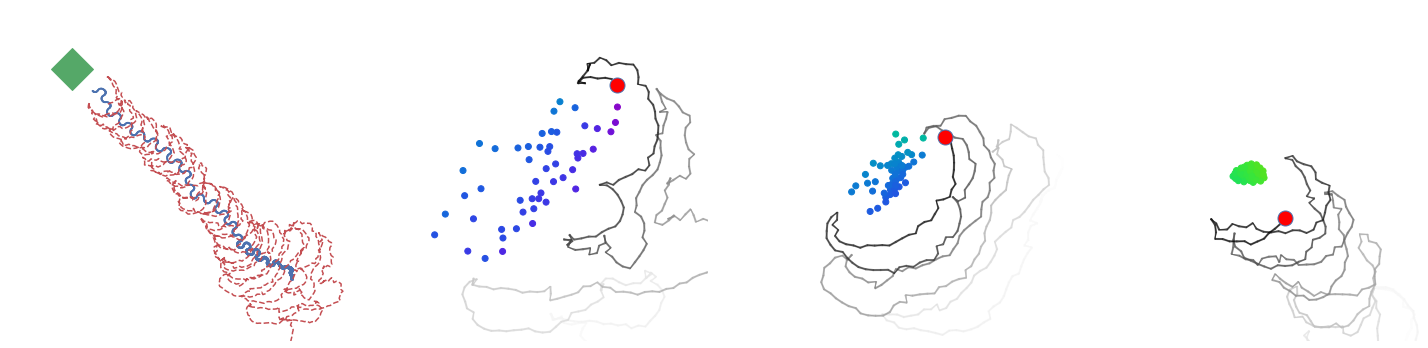

1
Looking at data & performing sanity checks...
There are  100 sheep!
There are  1 dogs!
There are 9759 frames of dumped data!


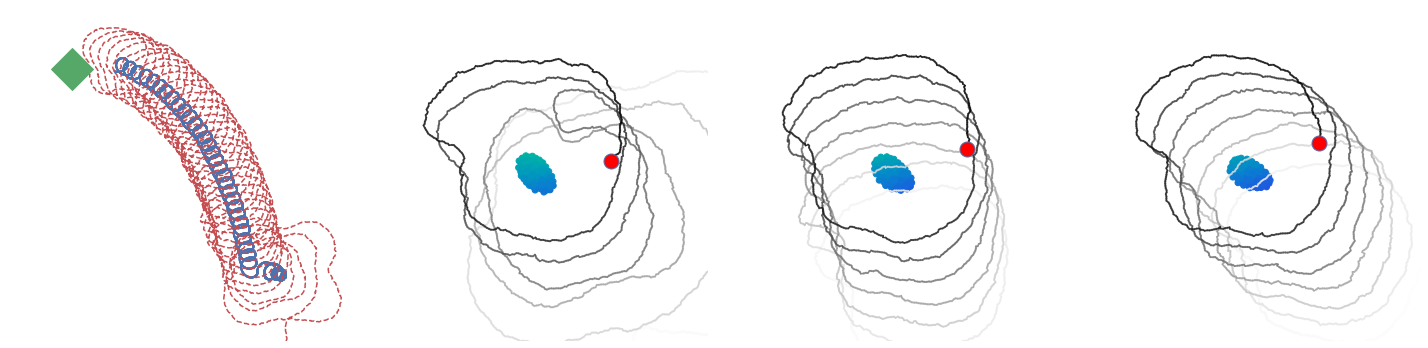

2
Looking at data & performing sanity checks...
There are  200 sheep!
There are  1 dogs!
There are 1496 frames of dumped data!


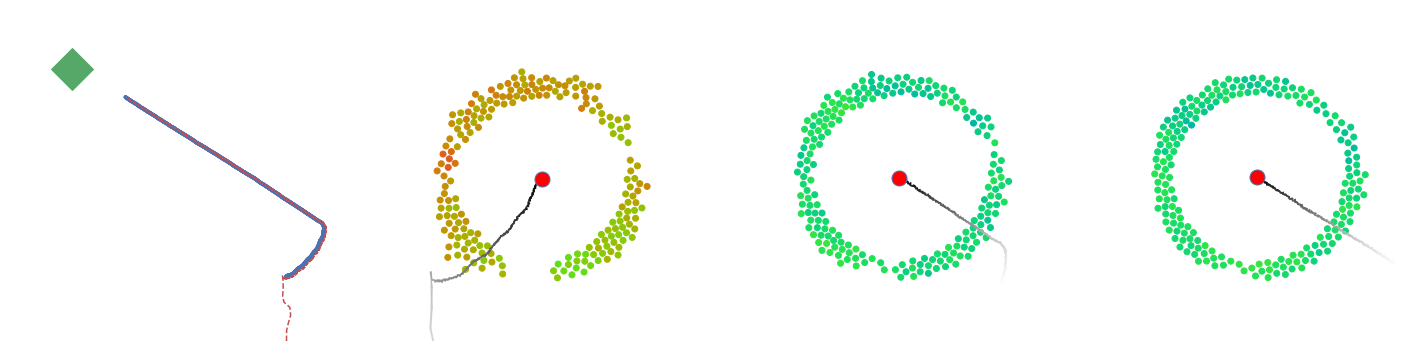

In [161]:
#-------------BEGIN LOAD DATA-------------------------------------------------------------

for selector in range(3):
    print(selector)
    #set_up_directories
    parent_folder = '/Users/adityaranganathan/Dropbox/Harvard_Research/repos/herding_parent/herding_new/SI_videos/'
    sub_folders = ['droving_slow', 'mustering_slow', 'driving']
    archived_sub_folders = ['droving', 'mustering']
    change_dir_to = parent_folder + sub_folders[selector]
    os.chdir(change_dir_to)


    #load the parameter files

    L = 6 #size of domain to plot
    dt = 0.05 #manually setting the timestep size (should eventually be grabbed from load_params_auto)

    #start timing
    t0 = time.time()

    #import data files
    dat_field = np.loadtxt('data.txt') #x,y position data for herd and dogs
    #dat_field = np.loadtxt('driving_data_SIVid.txt') #x,y position data for herd and dogs

    #load info from parameter file
    driving_on, x_target, y_target, vs, vd, ls, ld, fence, num_particles, ndogs, modder = load_params_auto('params.txt')

    #load info from data file
    xpart, ypart, thetapart, x_dogs, y_dogs, dat_times, timesteps, times, = load_data(dat_field, num_particles)


    #sanity checks
    sanity_checks(dat_field, num_particles, ndogs, timesteps)

    #temporary function to load the data from the costdata file
    costdata_full_array = np.loadtxt('costdata.txt')
    l4_norm  = costdata_full_array[:,3]
    xcm_herd = costdata_full_array[:,4]
    ycm_herd = costdata_full_array[:,5]
    x_dog = costdata_full_array[:,6]
    y_dog = costdata_full_array[:,7]
    
    tmp_name = "trajsnapshots_" + sub_folders[selector]+".png"
    make_row(tmp_name)

In [160]:
def make_row(name):
    
    row = 1
    scale = 1.5
    history_time = np.int(timesteps/5)
    target_marker_size = 30
    

    fig = plt.figure(figsize = (20,5))
    ax1 = fig.add_subplot(row*100+41)
    ax2 = fig.add_subplot(row*100+42)
    ax3 = fig.add_subplot(row*100+43)
    ax4 = fig.add_subplot(row*100+44)
    ax1.scatter(xcm_herd, ycm_herd, s=l4_norm*10, label = "average flock position")
    ax1.plot(x_dog, y_dog, 'r--', label = "shepherd")
    ax1.plot(x_target, y_target, 'gD', markersize = target_marker_size)
    ax1.set_xlim(x_target-scale, scale)
    ax1.set_ylim(-scale, y_target+scale)
    #ax1.legend()
    
    
    ax1.axis("off")
    ax2.axis("off")
    ax3.axis("off")
    ax4.axis("off")

    t = np.int(history_time)
    index = num_particles*t
    tmp_x = xpart[index: index+num_particles]
    tmp_y = ypart[index: index+num_particles]
    tmp_theta = thetapart[index: index+num_particles]
    ax2.plot(x_dog[t], y_dog[t], "o", mfc='red', linewidth = 8, markersize = 15)
    ax2.scatter(tmp_x, tmp_y, c = [colorator(iii) for iii in tmp_theta])
    ax2.set_xlim(np.average(tmp_x)-scale, np.average(tmp_x)+scale)
    ax2.set_ylim(np.average(tmp_y)-scale, np.average(tmp_y)+scale)
    xd, yd, zd = colored_line(x_dog[t-history_time:t], y_dog[t-history_time:t], 1, linewidth = .01)
    ax2.pcolormesh(xd, yd, zd, shading='gouraud', cmap='Greys', label = 'Dogs', alpha = 0.5)

    t = np.int(2*history_time)
    index = num_particles*t
    tmp_x = xpart[index: index+num_particles]
    tmp_y = ypart[index: index+num_particles]
    tmp_theta = thetapart[index: index+num_particles]
    ax3.plot(x_dog[t], y_dog[t], "o", mfc='red', linewidth = 8, markersize = 15)
    ax3.scatter(tmp_x, tmp_y, c = [colorator(iii) for iii in tmp_theta])
    ax3.set_xlim(np.average(tmp_x)-scale, np.average(tmp_x)+scale)
    ax3.set_ylim(np.average(tmp_y)-scale, np.average(tmp_y)+scale)
    xd, yd, zd = colored_line(x_dog[t-history_time:t], y_dog[t-history_time:t], 1, linewidth = .01)
    ax3.pcolormesh(xd, yd, zd, shading='gouraud', cmap='Greys', label = 'Dogs', alpha = 0.5)
    
    t = np.int(4*history_time)
    index = num_particles*t
    tmp_x = xpart[index: index+num_particles]
    tmp_y = ypart[index: index+num_particles]
    tmp_theta = thetapart[index: index+num_particles]
    ax4.plot(x_dog[t], y_dog[t], "o", mfc='red', linewidth = 8, markersize = 15)
    ax4.scatter(tmp_x, tmp_y, c = [colorator(iii) for iii in tmp_theta])
    ax4.set_xlim(np.average(tmp_x)-scale, np.average(tmp_x)+scale)
    ax4.set_ylim(np.average(tmp_y)-scale, np.average(tmp_y)+scale)
    xd, yd, zd = colored_line(x_dog[t-history_time:t], y_dog[t-history_time:t], 1, linewidth = .01)
    ax4.pcolormesh(xd, yd, zd, shading='gouraud', cmap='Greys', label = 'Dogs', alpha = 0.5)
    
    fig.tight_layout()
    
    plt.savefig(name)

    plt.show()

In [108]:
make_row()

In [128]:
angle_array = np.linspace(-np.pi, np.pi, 500)
#angle_array = [ii - tmp_target_angle for ii in angle_array]
x_offset = scale-scale/4
y_offset = scale-scale/4
x_colors_p = scale/5*np.cos(angle_array)
y_colors_p = scale/5*np.sin(angle_array)
angle_colors = [colorator(p) for p in angle_array]
ax1.scatter(x_colors, y_colors, color = angle_colors)

NameError: name 'x_colors' is not defined